In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s]


Epoch [1/10] - Loss: 0.0258 - Accuracy: 0.9880
Epoch [2/10] - Loss: 0.0005 - Accuracy: 1.0000
Epoch [3/10] - Loss: 0.0001 - Accuracy: 1.0000
Epoch [4/10] - Loss: 0.0001 - Accuracy: 1.0000
Epoch [5/10] - Loss: 0.0002 - Accuracy: 1.0000
Epoch [6/10] - Loss: 0.0001 - Accuracy: 1.0000
Epoch [7/10] - Loss: 0.0001 - Accuracy: 1.0000
Epoch [8/10] - Loss: 0.0001 - Accuracy: 1.0000
Epoch [9/10] - Loss: 0.0001 - Accuracy: 1.0000
Epoch [10/10] - Loss: 0.0001 - Accuracy: 1.0000
Training complete!
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


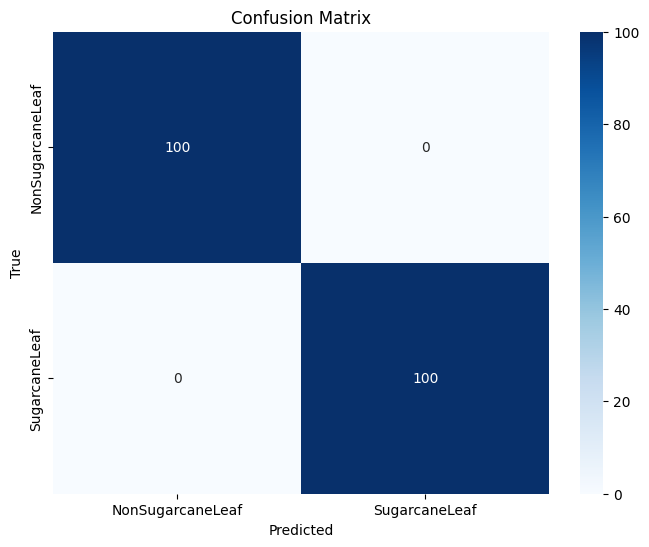

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Set seed for reproducibility
def set_seed(seed=42):
    import random, numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 2. Define mean and std used for normalization
mean = [0.485, 0.456, 0.406]  # Example values (ImageNet standard)
std = [0.229, 0.224, 0.225]

# 3. Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit the model input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Normalization with ImageNet mean/std
])

# 4. Load dataset
data_dir = '/content/drive/MyDrive/verifiertraindata'  # Your dataset path
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Get class names
class_names = train_dataset.classes
num_classes = len(class_names)

# 5. Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 6. Initialize the model (ResNet18 with modified final layer for your number of classes)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust the final layer for your number of classes
model = model.to(device)

# 7. Define Loss function, Optimizer, and Learning Rate Scheduler
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Optimizer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler

# 8. Train the model
num_epochs = 10  # Set the number of epochs
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_preds += torch.sum(preds == labels).item()
        total_preds += labels.size(0)

    # Calculate average loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")

    # Check if we got the best accuracy so far
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        torch.save(model.state_dict(), '/content/drive/MyDrive/sugarcane_verifier.pth')  # Save the model with best accuracy

    # Step the scheduler
    scheduler.step()

print("Training complete!")

# 9. Save the final model
torch.save(model.state_dict(), '/content/drive/MyDrive/sugarcane_verifier_final.pth')


# 10. Evaluate model performance (Confusion Matrix and Metrics)

# Load the best model (or the final model if you don't want the best model)
model.load_state_dict(torch.load('/content/drive/MyDrive/sugarcane_verifier.pth'))
model = model.to(device)
model.eval()  # Set model to evaluation mode

# 11. Create test loader (you can replace with your test dataset path)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/verifiertestdata', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize lists to track predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():  # No need to track gradients during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predictions
        _, preds = torch.max(outputs, 1)

        # Append predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 12. Compute Precision, Recall, F1-Score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# 13. Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# 14. Print Performance Metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# 15. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Classes: ['BandedChlorosis', 'BrownSpot', 'Dried', 'GrassyShoot', 'Healthy', 'PokkahBoeng', 'SettRot', 'Smut', 'ViralDisease']
Using device: cuda
Epoch [1/30] Loss: 40.7527 Val Acc: 84.69% Train Acc: 58.92%
Average Validation Confidence: 0.78
Epoch [2/30] Loss: 9.0454 Val Acc: 95.31% Train Acc: 89.62%
Average Validation Confidence: 0.94
Epoch [3/30] Loss: 5.2767 Val Acc: 97.53% Train Acc: 94.65%
Average Validation Confidence: 0.97
Epoch [4/30] Loss: 2.9669 Val Acc: 97.53% Train Acc: 96.66%
Average Validation Confidence: 0.97
Epoch [5/30] Loss: 2.4820 Val Acc: 98.02% Train Acc: 97.46%
Average Validation Confidence: 0.98
Epoch [6/30] Loss: 2.5834 Val Acc: 98.77% Train Acc: 97.67%
Average Validation Confidence: 0.98
Epoch [7/30] Loss: 2.2149 Val Acc: 98.02% Train Acc: 97.51%
Average Validation Confidence: 0.97
Epoch [8/30] Loss: 1.2317 Val Acc: 98.77% Train Acc: 98.73%
Average Validation Confidence: 0.99
Epoch [9/30] Loss: 2.0301 Val Acc: 98.77% Train Acc: 97.78%
Average Validation Confid

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


Invalid images rejected: 0


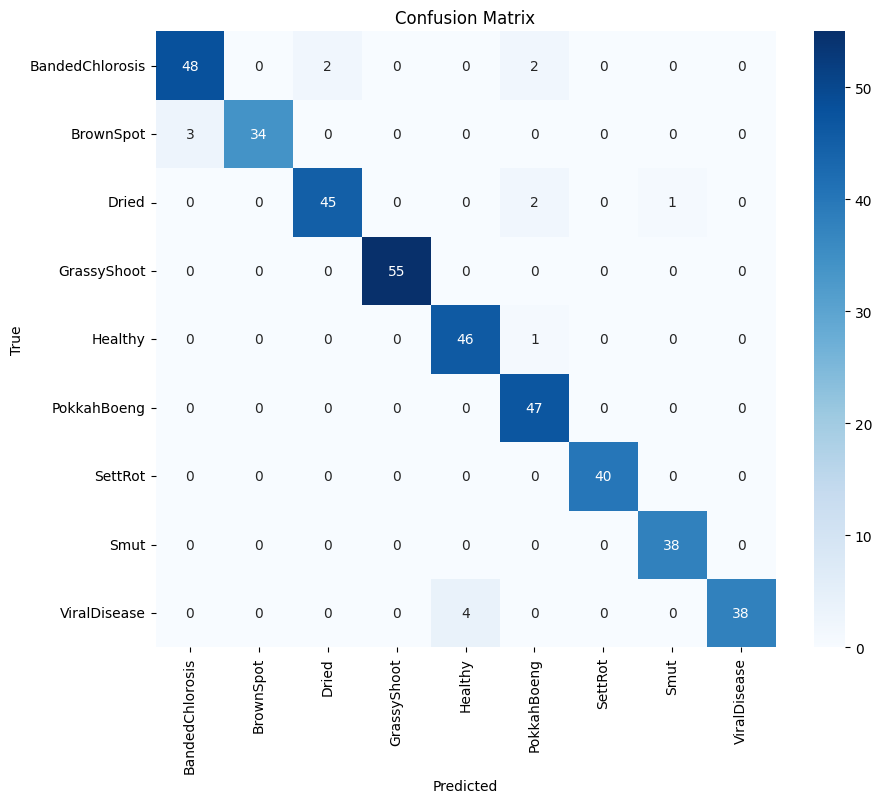

                 precision    recall  f1-score   support

BandedChlorosis       0.94      0.92      0.93        52
      BrownSpot       1.00      0.92      0.96        37
          Dried       0.96      0.94      0.95        48
    GrassyShoot       1.00      1.00      1.00        55
        Healthy       0.92      0.98      0.95        47
    PokkahBoeng       0.90      1.00      0.95        47
        SettRot       1.00      1.00      1.00        40
           Smut       0.97      1.00      0.99        38
   ViralDisease       1.00      0.90      0.95        42

       accuracy                           0.96       406
      macro avg       0.97      0.96      0.96       406
   weighted avg       0.96      0.96      0.96       406



In [5]:
import os
import shutil
import numpy as np
import torch
import timm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import torch.nn.functional as F

# 1. Dataset directory
data_dir = '/content/drive/MyDrive/NewData'

# 2. Seed setup
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 3. Normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# 4. Transformations
train_val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([
        transforms.RandomRotation(40),
        transforms.ColorJitter(brightness=0.5, contrast=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=15),
    ], p=0.9),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

smut_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 5. Load dataset WITHOUT transform for now
base_dataset = datasets.ImageFolder(root=data_dir)

# 6. Custom dataset wrapper to apply class-specific transforms
class CustomTransformDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, class_names, default_transform, smut_transform):
        self.base_dataset = base_dataset
        self.class_names = class_names
        self.default_transform = default_transform
        self.smut_transform = smut_transform
        # Find index of Smut class for checking
        self.smut_class_idx = self.class_names.index('Smut') if 'Smut' in self.class_names else -1

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        if label == self.smut_class_idx:
            image = self.smut_transform(image)
        else:
            image = self.default_transform(image)
        return image, label

# 7. Setup dataset with custom transforms
class_names = base_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

full_dataset = CustomTransformDataset(base_dataset, class_names, train_val_transforms, smut_transforms)

# 8. Dataset splitting
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# 9. Dataloaders
batch_size = 64
num_workers = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 10. CBAM class
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_att = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_att(x)
        x = x * ca
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        sa = self.spatial_att(torch.cat([max_pool, avg_pool], dim=1))
        x = x * sa
        return x

# 11. EfficientNet + CBAM
class EfficientNetCBAM(nn.Module):
    def __init__(self):
        super(EfficientNetCBAM, self).__init__()
        self.backbone = timm.create_model('efficientnet_b1', pretrained=True, num_classes=0)
        self.cbam = CBAM(1280)

    def forward(self, x):
        x = self.backbone.forward_features(x)
        x = self.cbam(x)
        x = x.permute(0, 2, 3, 1).reshape(x.size(0), -1, x.size(1))
        return x

# 12. GRU Classifier
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

# 13. Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
feature_extractor = EfficientNetCBAM().to(device)
gruc = GRUClassifier(input_size=1280, hidden_size=512, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(feature_extractor.parameters()) + list(gruc.parameters()), lr=1e-4)

# 14. Training loop
best_val_acc = 0
patience_counter = 0
early_stopping_patience = 3
epochs = 30

for epoch in range(epochs):
    feature_extractor.train()
    gruc.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        features = feature_extractor(images)
        outputs = gruc(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_acc = 100. * correct / total

    feature_extractor.eval()
    gruc.eval()
    val_correct = 0
    val_total = 0
    val_probs = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            outputs = gruc(features)
            probs = torch.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probs, 1)
            val_probs.extend(max_probs.cpu().numpy())
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    avg_val_confidence = np.mean(val_probs)
    val_acc = 100. * val_correct / val_total
    print(f'Epoch [{epoch+1}/{epochs}] Loss: {running_loss:.4f} Val Acc: {val_acc:.2f}% Train Acc: {train_acc:.2f}%')
    print(f'Average Validation Confidence: {avg_val_confidence:.2f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(feature_extractor.state_dict(), '/content/drive/MyDrive/feature_extractor_best.pth')
        torch.save(gruc.state_dict(), '/content/drive/MyDrive/gru_classifier_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            print(f"Final Training Accuracy: {train_acc:.2f}%")
            break

# 15. Load best models
feature_extractor.load_state_dict(torch.load('/content/drive/MyDrive/feature_extractor_best.pth'))
gruc.load_state_dict(torch.load('/content/drive/MyDrive/gru_classifier_best.pth'))
feature_extractor.eval()
gruc.eval()

# 16. Load sugarcane verifier
sugarcane_verifier = models.resnet18(pretrained=False)
sugarcane_verifier.fc = nn.Linear(sugarcane_verifier.fc.in_features, 2)
sugarcane_verifier.load_state_dict(torch.load('/content/drive/MyDrive/sugarcane_verifier.pth'))
sugarcane_verifier = sugarcane_verifier.to(device)
sugarcane_verifier.eval()

# 17. Testing with verification
all_preds = []
all_labels = []
invalid_count = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        verifier_outputs = sugarcane_verifier(images)
        _, verifier_preds = torch.max(verifier_outputs, 1)

        for i in range(images.size(0)):
            if verifier_preds[i].item() == 1:  # 1 means sugarcane leaf
                feat = feature_extractor(images[i].unsqueeze(0))
                output = gruc(feat)
                pred = output.argmax(dim=1).item()
                all_preds.append(pred)
                all_labels.append(labels[i].item())
            else:
                invalid_count += 1
                # Optionally append an "invalid" label or ignore

print(f"Invalid images rejected: {invalid_count}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_preds, target_names=class_names))


In [6]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4f915b1d0ea1004727c77415d08ed37c197ca80213e0e5024a19f9bb4f10197d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [10]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
from PIL import Image

# Transforms
user_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load models (already trained & saved)
feature_extractor.load_state_dict(torch.load('/content/drive/MyDrive/feature_extractor_best.pth'))
gruc.load_state_dict(torch.load('/content/drive/MyDrive/gru_classifier_best.pth'))
sugarcane_verifier.load_state_dict(torch.load('/content/drive/MyDrive/sugarcane_verifier.pth'))

feature_extractor.eval()
gruc.eval()
sugarcane_verifier.eval()

# Load input image
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    tensor_img = user_transforms(img).unsqueeze(0).to(device)
    return img, tensor_img

# Sugarcane Verification
def is_sugarcane_leaf(tensor_img):
    with torch.no_grad():
        output = sugarcane_verifier(tensor_img)
        pred = output.argmax(dim=1).item()
    return pred == 1  # Assuming class 1 = sugarcane leaf

# Prediction
def predict_class(tensor_img):
    with torch.no_grad():
        features = feature_extractor(tensor_img)
        output = gruc(features)
        pred_class = output.argmax(dim=1).item()
    return pred_class, output.softmax(dim=1).max().item()

# LIME explainer
def explain_prediction(image_path):
    img, tensor_img = load_image(image_path)

    if not is_sugarcane_leaf(tensor_img):
        print("The image is NOT a sugarcane leaf. Rejected.")
        return

    print("Verified as sugarcane leaf.")
    class_id, confidence = predict_class(tensor_img)
    print(f"Predicted Class: {class_names[class_id]} (Confidence: {confidence:.2f})")

    # LIME expects numpy image and prediction function
    def lime_predict(images_np):
        imgs_tensor = []
        for img_np in images_np:
            img_pil = Image.fromarray(img_np)
            img_tensor = user_transforms(img_pil).unsqueeze(0)
            imgs_tensor.append(img_tensor)
        batch_tensor = torch.cat(imgs_tensor).to(device)

        with torch.no_grad():
            features = feature_extractor(batch_tensor)
            outputs = gruc(features)
            probs = torch.nn.functional.softmax(outputs, dim=1)
        return probs.cpu().numpy()

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        np.array(img),
        lime_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=class_id,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    plt.figure(figsize=(8, 8))
    plt.title(f"LIME Explanation for Class: {class_names[class_id]}")
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')
    plt.show()

# Example usage
image_path = "/content/drive/MyDrive/verifiertestdata/NonSugarcaneLeaf/SugarcaneLeaf (11).JPG"  # Change this to your test image
explain_prediction(image_path)


The image is NOT a sugarcane leaf. Rejected.
